**Goal**

1. Finding out which variable affects the rental price the most for three cities: Berlin, Monachium, Prague
2. Study diffirent algorithms used for regression analysis


**Prereqs**

1. Ensure input files are presented on Google disc.
   Source file listing_summary.csv should be there.
   Otherwise upload is directly to Colab filesystem.
   In this notebook I'm using files directly from my Google Drive.
   Please replace all path to source data with proper one
   (take value from copy path for source files)
2. Install shap library
3. Output files
   Some code produces images which are stored. If you interested to store them pernamently update the path to store them in your google driver or download them before ending work with notebook.

**Source data**

 1. listings_berlin_11_2019.csv
 2. listings_munich_11_2019.csv
 3. listings_prague_11_2019.csv
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 26.1 MB/s 


In [ ]:
import pandas as pd # for data manipulation
import numpy as np  # fast n-dimensional arrays library
import statsmodels.formula.api as smf # for linear regresion
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
from sklearn import preprocessing # for preprocessing for LASSO algorithm
from sklearn.metrics import mean_squared_error # metric for comparing models
from sklearn import linear_model # for LASSO algorithm
import xgboost # for XGBoost algorithm
import shap # for visualization output from XGBoost
from PIL import Image # for images manipulation

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Lest save information about exact version of libraries used.

In [ ]:
print("Version of libraries used")
print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
import statsmodels as lib
print("statsmodels: " + lib.__version__)
del lib
print("sns: " + sns.__version__)
import matplotlib as lib
print("matplotlib.pyplot: " + lib.__version__)
del lib
import sklearn as lib
print("sklearn: " + lib.__version__)
del lib
print("xgboost: " + xgboost.__version__)
print("shap: " + shap.__version__)
import PIL as lib
print("PIL: " + lib.__version__)
del lib

Version of libraries used
pandas: 1.1.5
numpy: 1.19.5
statsmodels: 0.10.2
sns: 0.11.2
matplotlib.pyplot: 3.2.2
sklearn: 1.0.2
xgboost: 0.90
shap: 0.40.0
PIL: 7.1.2


**Read data and exploratory analysis**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/listings_berlin_11_2019.csv') # orginal berlin

In [ ]:
data.head()

id  ... reviews_per_month
0  2015  ...              3.76
1  2695  ...              1.42
2  3176  ...              1.25
3  3309  ...              0.39
4  7071  ...              1.75

[5 rows x 96 columns]

In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/listings_munich_11_2019.csv') # monachium

Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
data3 = pd.read_csv('/content/drive/MyDrive/listings_prague_11_2019.csv') # prague

In [ ]:
data3.head()

id  ... reviews_per_month
0   3884  ...              0.02
1  23163  ...              0.15
2  23169  ...              0.59
3  26755  ...              3.15
4  27916  ...              2.98

[5 rows x 74 columns]

In [ ]:
# Preprocessing - cast price as float
data.price = data.price.apply(lambda x: x.replace("$", ""))
data.price = data.price.apply(lambda x: x.replace(",", ""))
data.price = data.price.astype("float")
data.price.describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

In [ ]:
# Preprocessing - cast price as float
data2.price = data2.price.apply(lambda x: x.replace("$", ""))
data2.price = data2.price.apply(lambda x: x.replace(",", ""))
data2.price = data2.price.astype("float")
data2.price.describe()

count    11481.000000
mean       116.336469
std        168.078321
min          8.000000
25%         55.000000
50%         82.000000
75%        130.000000
max       9000.000000
Name: price, dtype: float64

In [ ]:
# Preprocessing - cast price as float
data3.price = data3.price.apply(lambda x: x.replace("$", ""))
data3.price = data3.price.apply(lambda x: x.replace(",", ""))
data3.price = data3.price.astype("float")
data3.price.describe()

count    6.782000e+03
mean     9.016939e+03
std      1.282461e+05
min      0.000000e+00
25%      1.113250e+03
50%      1.705000e+03
75%      2.762750e+03
max      2.866213e+06
Name: price, dtype: float64

In [ ]:
# Enrich data by calculate zip code relation to price
# amenities_len -> value for comparing number of amenities across offerts
# zip_count -> number of offerts in close location
# zip_price -> average price for offerts in the same location

temp_zipcode = data.zipcode.copy()
data['zipcode2'] = temp_zipcode.str.replace("\D+", "", ).copy()
data.zipcode2.fillna(0, inplace=True)
x_count = data.groupby('zipcode2')['id'].nunique()
x_mean = data.groupby('zipcode2')['price'].mean()

x_count_dict = x_count.to_dict()
x_mean_dict = x_mean.to_dict()

a1 = np.zeros((len(data), 6))
print(a1)
for i in range(0,len(data)):
    val = data.zipcode2[i]
    a1[i][0] = data.id[i]
    a1[i][1] = x_count_dict[val]
    a1[i][2] = x_mean_dict[val]
    a1[i][3] = val
    a1[i][4] = len(data.amenities[i])

data['amenities_len'] = a1[:,3]
data['zipcode_count'] = a1[:,1]
data['zipcode_price'] = a1[:,2]
print(data.head())

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
     id                        listing_url  ...  zipcode_count zipcode_price
0  2015  https://www.airbnb.com/rooms/2015  ...          538.0     88.500000
1  2695  https://www.airbnb.com/rooms/2695  ...          703.0     80.765292
2  3176  https://www.airbnb.com/rooms/3176  ...          585.0     68.446154
3  3309  https://www.airbnb.com/rooms/3309  ...          183.0    112.234973
4  7071  https://www.airbnb.com/rooms/7071  ...          703.0     80.765292

[5 rows x 100 columns]


In [ ]:
# Enrich data by calculate zip code relation to price
# amenities_len -> value for comparing number of amenities across offerts
# zip_count -> number of offerts in close location
# zip_price -> average price for offerts in the same location

temp_zipcode = data2.zipcode.copy()
data2['zipcode2'] = temp_zipcode.str.replace("\D+", "", ).copy()

data2.zipcode2.fillna(0, inplace=True)

x_count = data2.groupby('zipcode2')['id'].nunique()
x_mean = data2.groupby('zipcode2')['price'].mean()

x_count_dict = x_count.to_dict()
x_mean_dict = x_mean.to_dict()

a1 = np.zeros((len(data2), 6))
print(a1)
for i in range(0,len(data2)):
    val = data2.zipcode2[i]
    a1[i][0] = data2.id[i]
    a1[i][1] = x_count_dict[val]
    a1[i][2] = x_mean_dict[val]
    a1[i][3] = val
    a1[i][4] = len(data2.amenities[i])

data2['amenities_len'] = a1[:,3]
data2['zipcode_count'] = a1[:,1]
data2['zipcode_price'] = a1[:,2]
print(data2.head())

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
       id                          listing_url  ...  zipcode_count zipcode_price
0   36720   https://www.airbnb.com/rooms/36720  ...          417.0    184.453237
1   97945   https://www.airbnb.com/rooms/97945  ...           50.0     84.460000
2  114695  https://www.airbnb.com/rooms/114695  ...           69.0    109.594203
3  127383  https://www.airbnb.com/rooms/127383  ...          201.0    124.527363
4  157808  https://www.airbnb.com/rooms/157808  ...          163.0    118.122699

[5 rows x 110 columns]


In [ ]:
# Enrich data by calculate zip code relation to price
# amenities_len -> value for comparing number of amenities across offerts
# zip_count -> number of offerts in close location
# zip_price -> average price for offerts in the same location

temp_zipcode = data2.zipcode.copy()
data3['zipcode2'] = temp_zipcode.str.replace("\D+", "", ).copy()

data3.zipcode2.fillna(0, inplace=True)

x_count = data3.groupby('zipcode2')['id'].nunique()
x_mean = data3.groupby('zipcode2')['price'].mean()

x_count_dict = x_count.to_dict()
x_mean_dict = x_mean.to_dict()

a1 = np.zeros((len(data3), 6))
print(a1)
for i in range(0,len(data3)):
    val = data3.zipcode2[i]
    a1[i][0] = data3.id[i]
    a1[i][1] = x_count_dict[val]
    a1[i][2] = x_mean_dict[val]
    a1[i][3] = val
    a1[i][4] = len(data3.amenities[i])

data3['amenities_len'] = a1[:,3]
data3['zipcode_count'] = a1[:,1]
data3['zipcode_price'] = a1[:,2]
print(data3.head())

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
      id                         listing_url  ...  zipcode_count zipcode_price
0   3884   https://www.airbnb.com/rooms/3884  ...          362.0  18629.168508
1  23163  https://www.airbnb.com/rooms/23163  ...           41.0   2690.560976
2  23169  https://www.airbnb.com/rooms/23169  ...           50.0   2129.060000
3  26755  https://www.airbnb.com/rooms/26755  ...          169.0   2999.792899
4  27916  https://www.airbnb.com/rooms/27916  ...          137.0  23789.394161

[5 rows x 78 columns]


In [ ]:
# Preprocessing - get rid of outliers
print("99.7% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.7)))
data = data[(data.price <= np.percentile(data.price, 99.7)) & (data.price > 0)]

99.7% properties have a price lower than  550.00


In [ ]:
# Preprocessing - get rid of outliers
print("99.7% properties have a price lower than {0: .2f}".format(np.percentile(data2.price, 99.7)))
data2 = data2[(data2.price <= np.percentile(data2.price, 99.7)) & (data2.price > 0)]

99.7% properties have a price lower than  999.00


In [ ]:
# Preprocessing - get rid of outliers
print("99.7% properties have a price lower than {0: .2f}".format(np.percentile(data3.price, 99.7)))
data3 = data3[(data3.price <= np.percentile(data3.price, 99.7)) & (data3.price > 0)]

99.7% properties have a price lower than  61282.69


Visualizing the important characteristics of a dataset

In [ ]:
cols = ['price', 'host_is_superhost', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'beds', 'bathrooms']
cols2 = ['accommodates', 'amenities_len', 'minimum_nights', 'zipcode_count', 'zipcode_price']
cols = cols + cols2
cols

['price',
 'host_is_superhost',
 'bedrooms',
 'number_of_reviews',
 'review_scores_rating',
 'beds',
 'bathrooms',
 'accommodates',
 'amenities_len',
 'minimum_nights',
 'zipcode_count',
 'zipcode_price']

In [ ]:
# Preprocessing - replace NaN values with mean from column
# With checking before and after replacement

print(data[cols].isna().sum())
print(data2[cols].isna().sum())
print(data3[cols].isna().sum())

data.fillna((data[cols].mean()), inplace=True)
data2.fillna((data2[cols].mean()), inplace=True)
data3.fillna((data3[cols].mean()), inplace=True)

# Why bathromes NaN not cleaned for Prague ?
data3['bathrooms'] = data3['bathrooms'].replace(np.nan, 0)

print(data[cols].isna().sum())
print(data2[cols].isna().sum())
print(data3[cols].isna().sum())


price                      0
host_is_superhost         25
bedrooms                  18
number_of_reviews          0
review_scores_rating    4349
beds                      39
bathrooms                 32
accommodates               0
amenities_len              0
minimum_nights             0
zipcode_count              0
zipcode_price              0
dtype: int64
price                      0
host_is_superhost         23
bedrooms                  30
number_of_reviews          0
review_scores_rating    2719
beds                      18
bathrooms                 21
accommodates               0
amenities_len              0
minimum_nights             0
zipcode_count              0
zipcode_price              0
dtype: int64
price                      0
host_is_superhost          0
bedrooms                 795
number_of_reviews          0
review_scores_rating     963
beds                     165
bathrooms               6752
accommodates               0
amenities_len              0
minimum_nights   

In [ ]:
# Convert remaining columns to float type
data['number_of_reviews'] = data['number_of_reviews'].astype(float)
data['accommodates'] = data['accommodates'].astype(float)
data['amenities_len'] = data['amenities_len'].astype(float)
data['minimum_nights'] = data['minimum_nights'].astype(float)

data2['number_of_reviews'] = data2['number_of_reviews'].astype(float)
data2['accommodates'] = data2['accommodates'].astype(float)
data2['amenities_len'] = data2['amenities_len'].astype(float)
data2['minimum_nights'] = data2['minimum_nights'].astype(float)

data3['number_of_reviews'] = data3['number_of_reviews'].astype(float)
data3['accommodates'] = data3['accommodates'].astype(float)
data3['amenities_len'] = data3['amenities_len'].astype(float)
data3['minimum_nights'] = data3['minimum_nights'].astype(float)

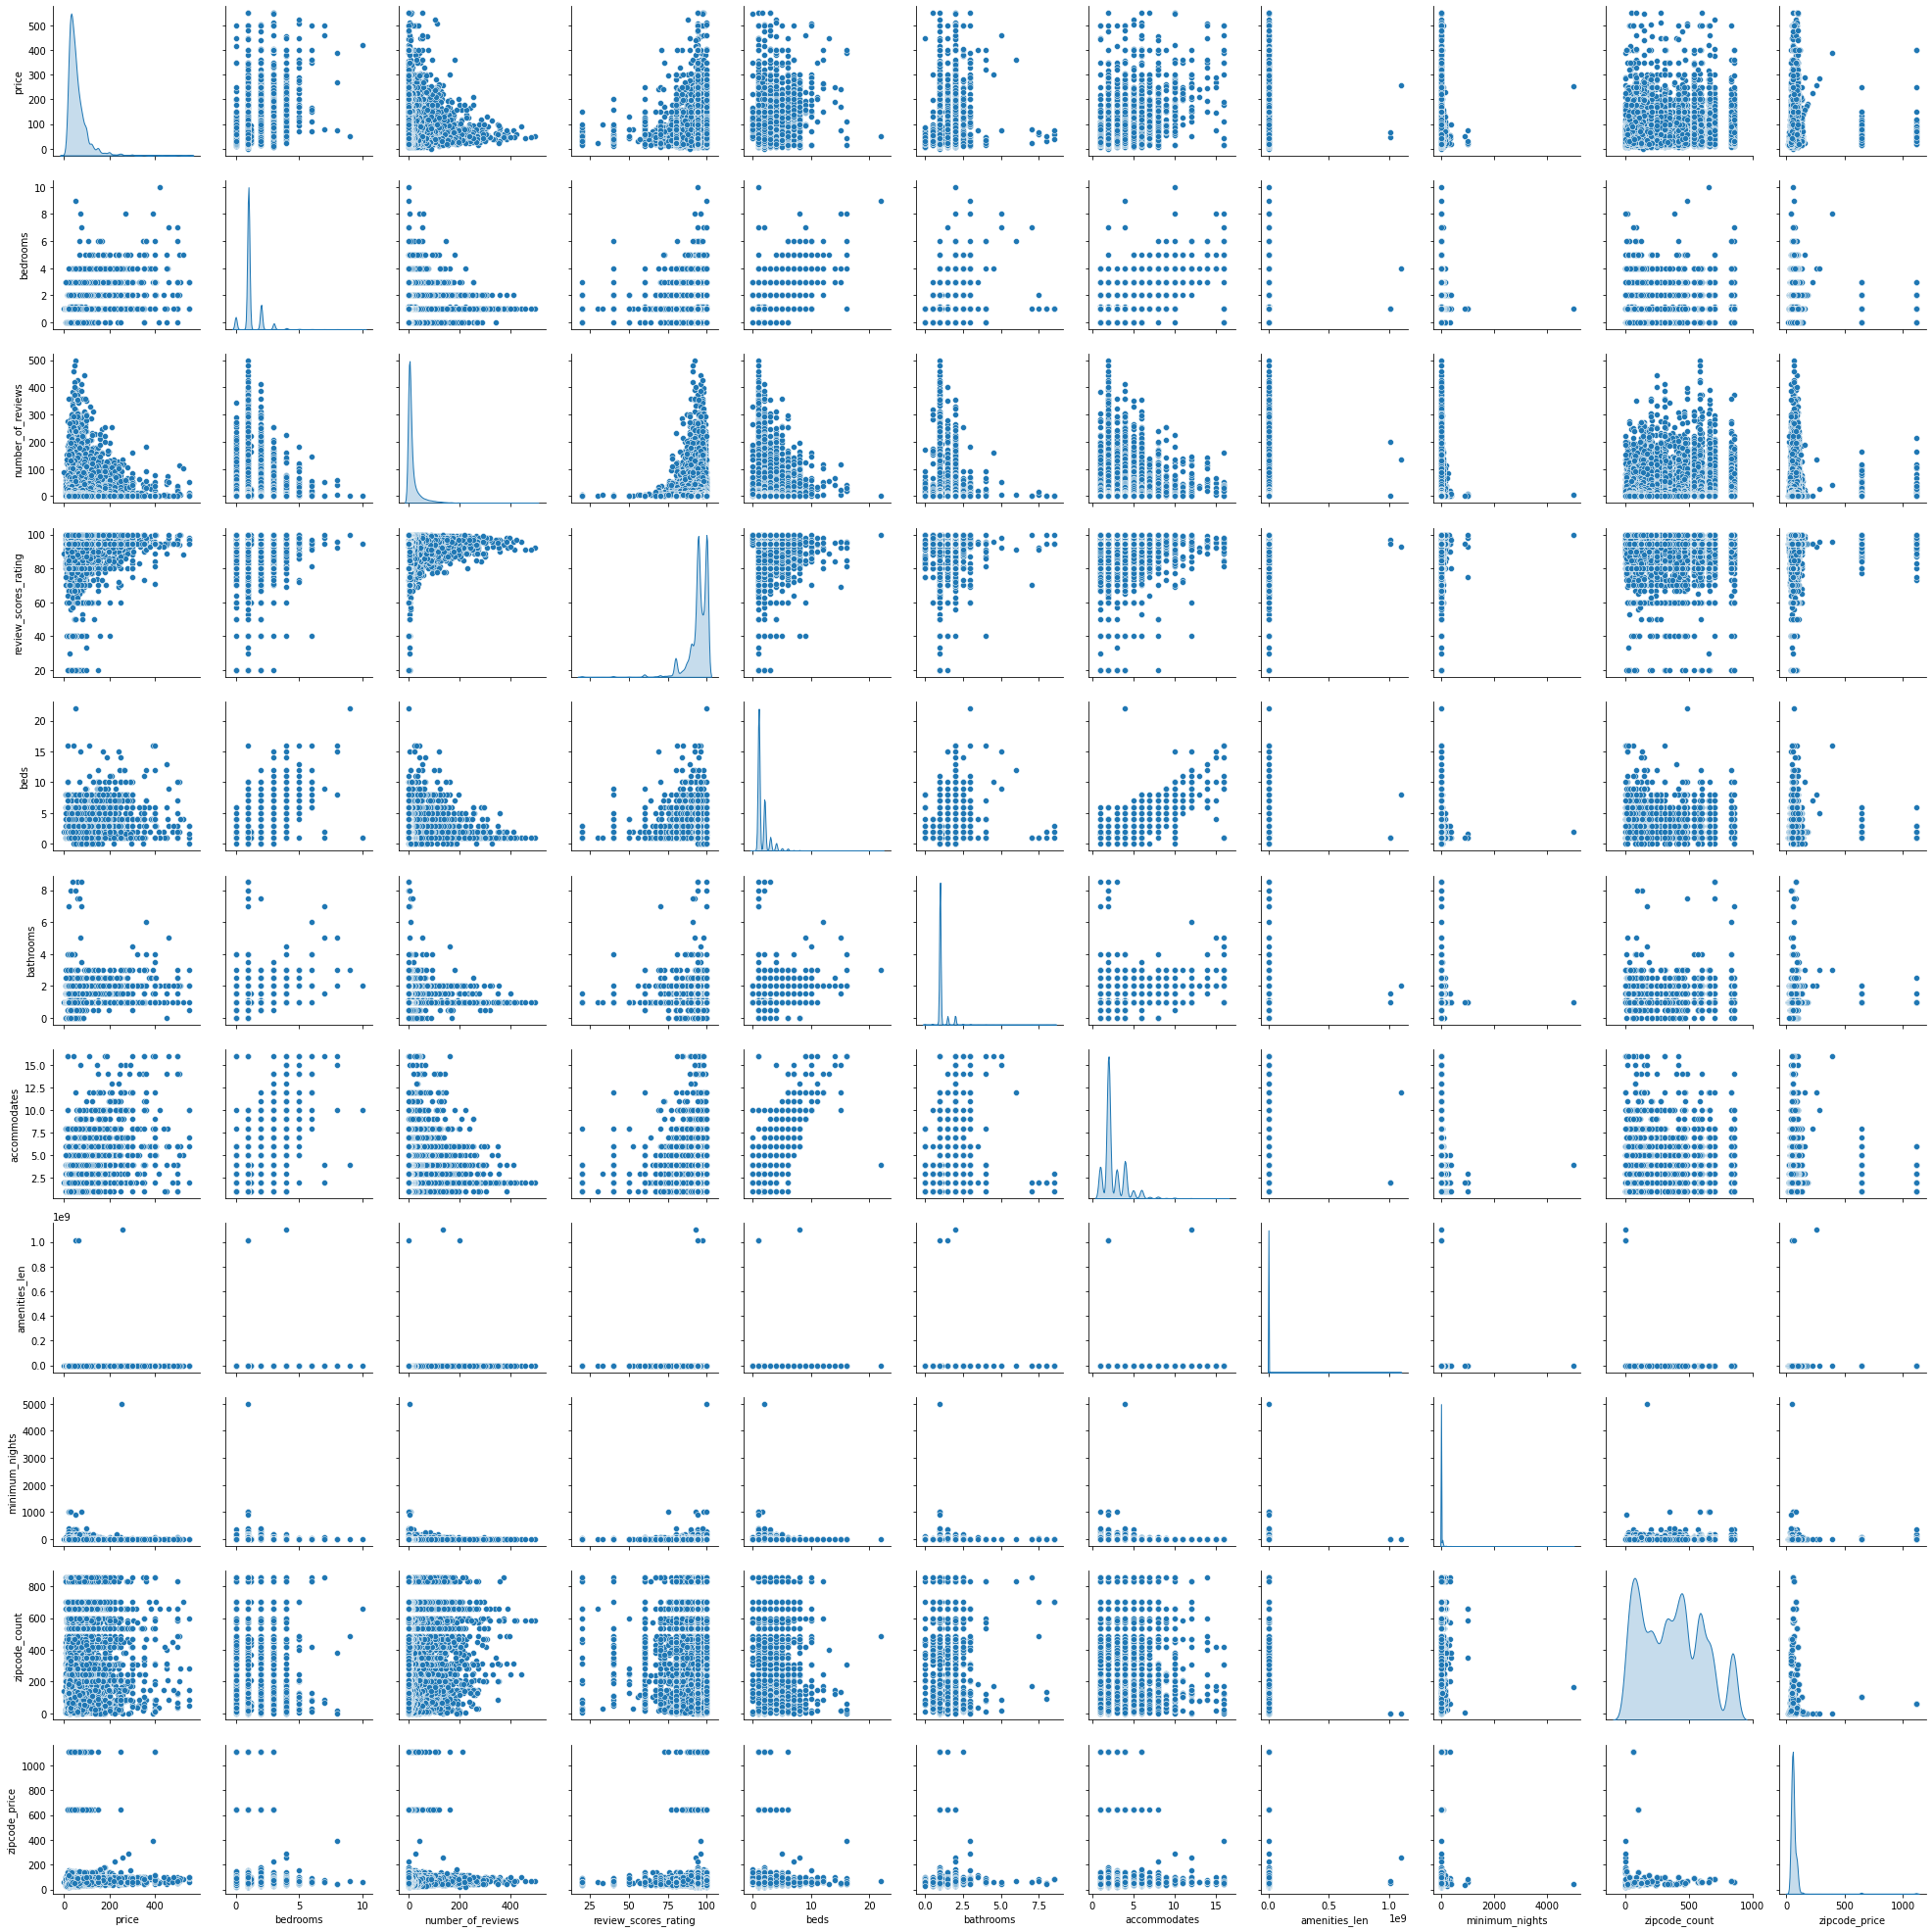

<Figure size 432x288 with 0 Axes>

In [ ]:
set_of_data =[data, data2, data3]
set_of_city = ['berlin', 'monachium', 'praga']

sns.pairplot(data[cols], height=2.5, diag_kind='kde')
plt.tight_layout()
plt.savefig('berlin_matrix_pair_plot.png', dpi=300)

plt.show()
plt.clf() # Clean parirplot figure from sns

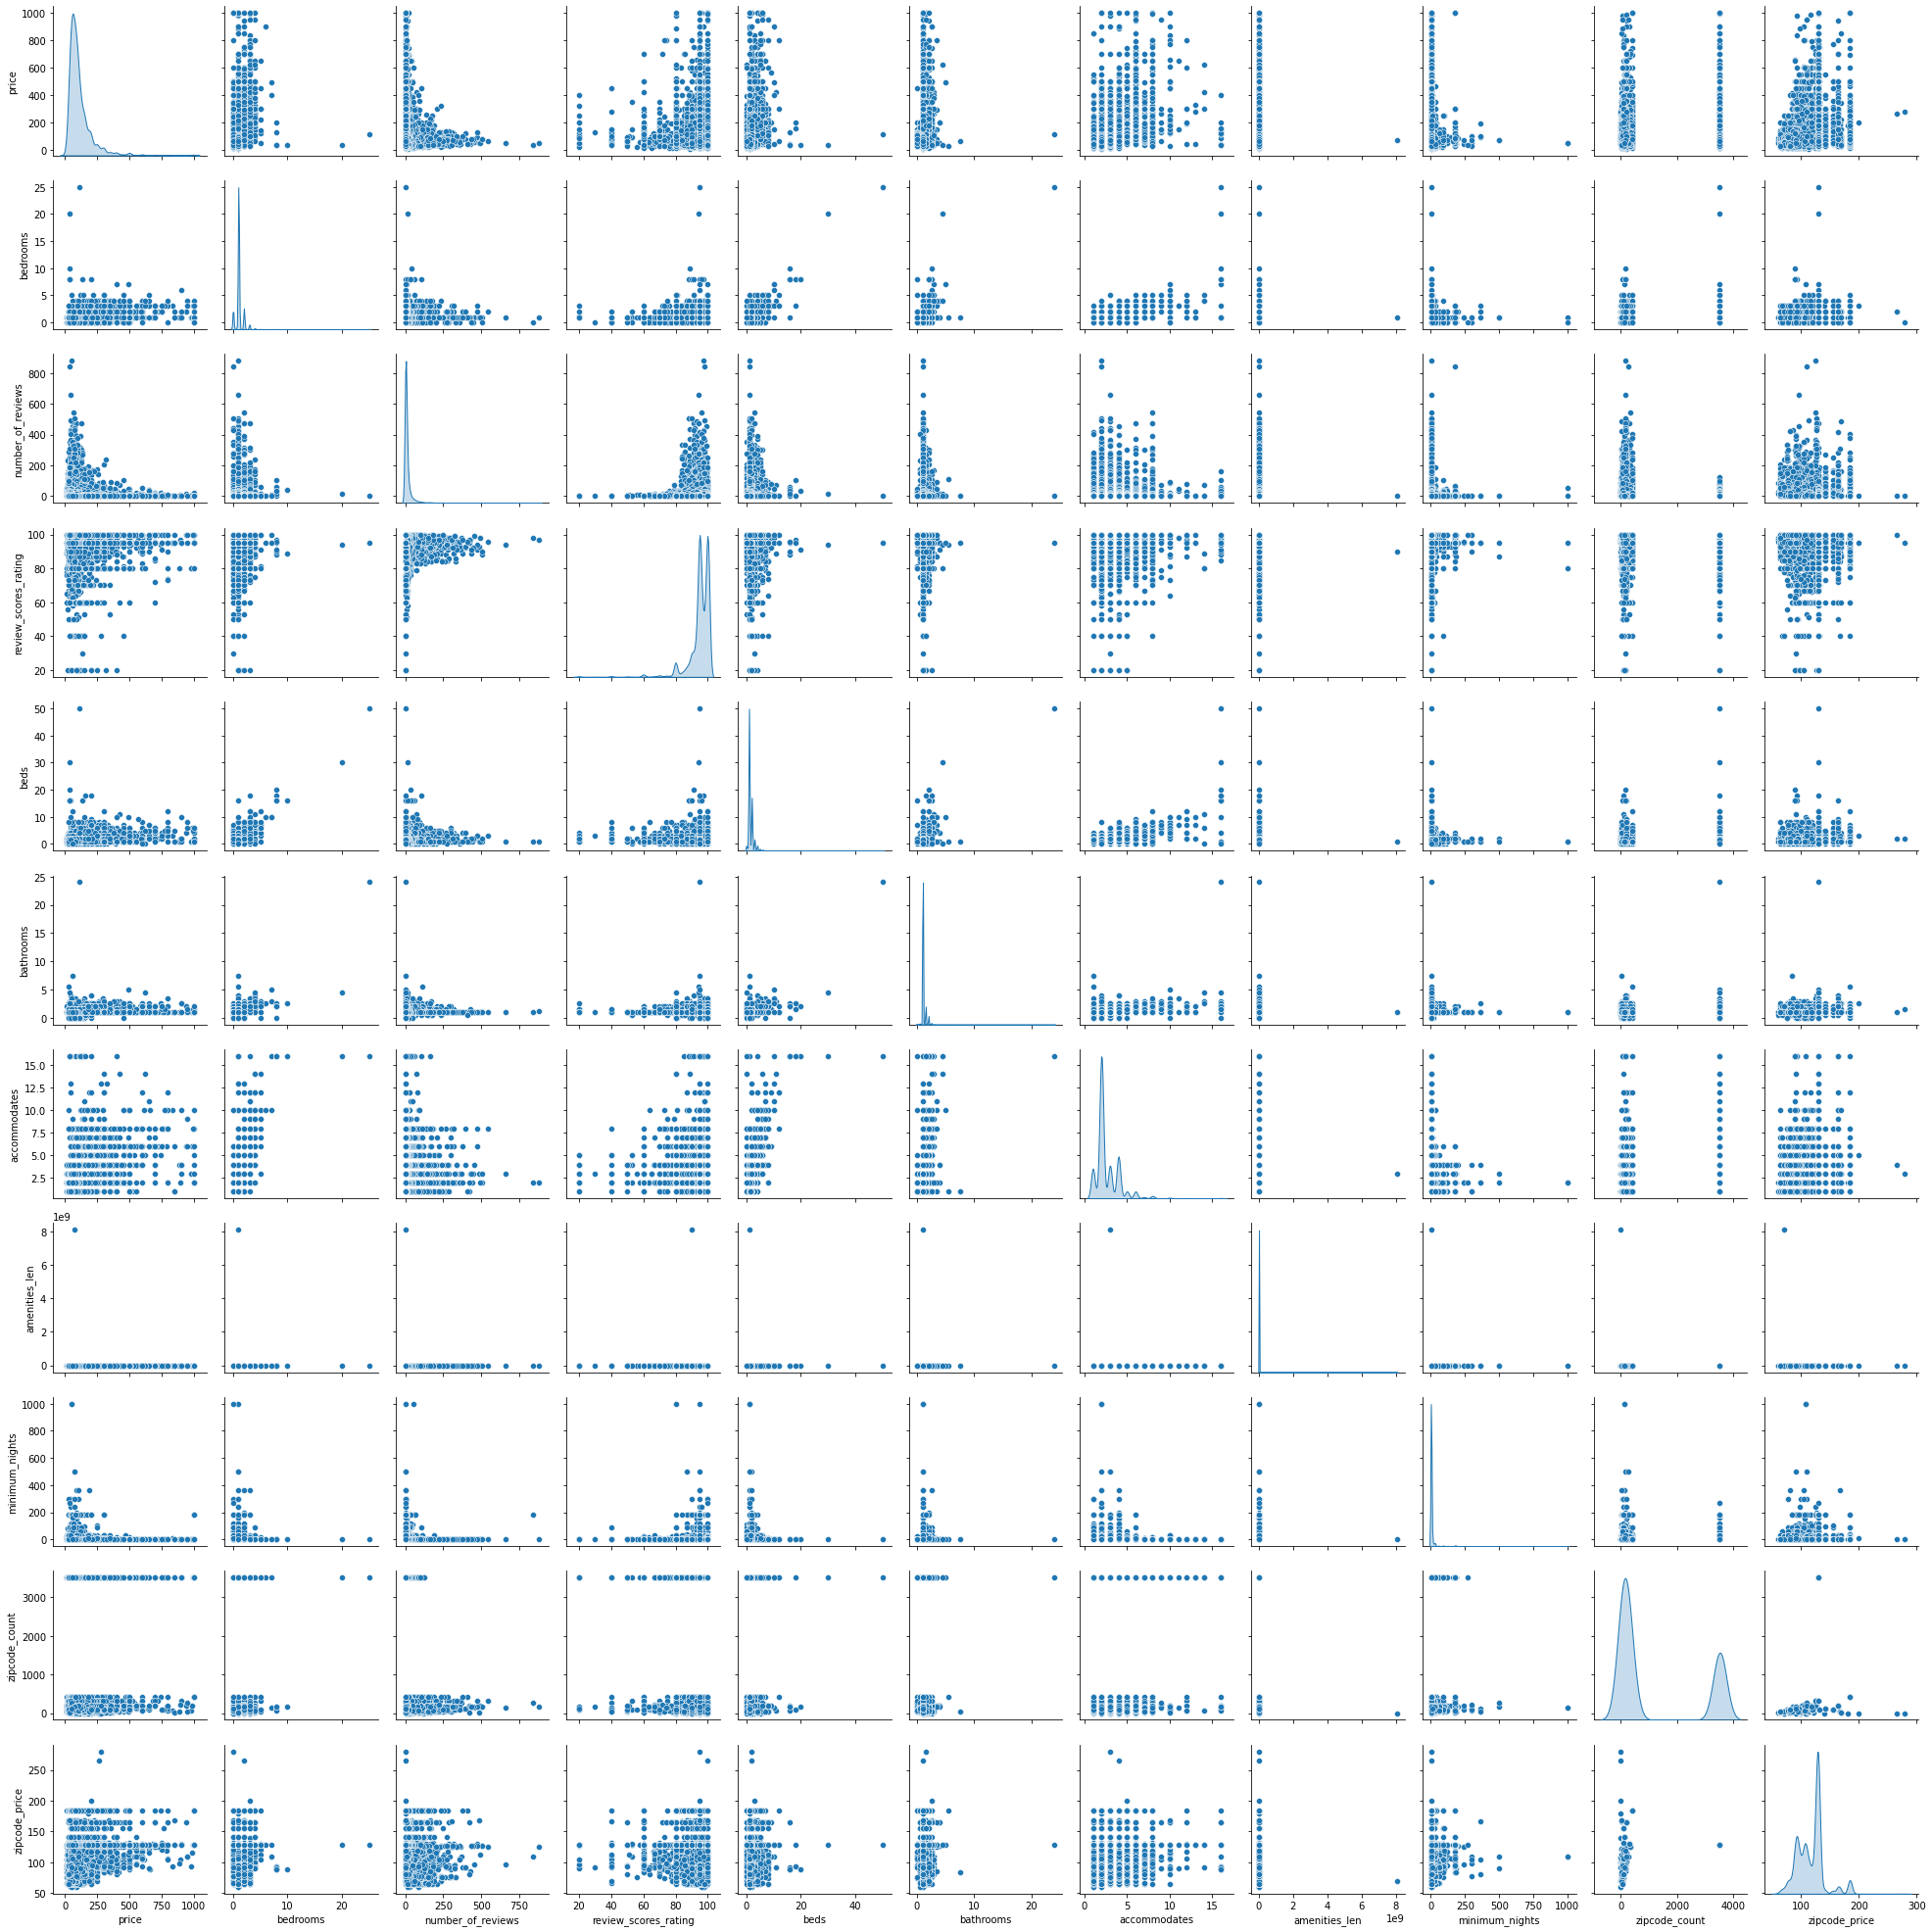

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.pairplot(data2[cols], height=2.5, diag_kind='kde')
plt.tight_layout()
plt.savefig('monachium_matrix_pair_plot.png', dpi=300)

plt.show()
plt.clf() # Clean parirplot figure from sns

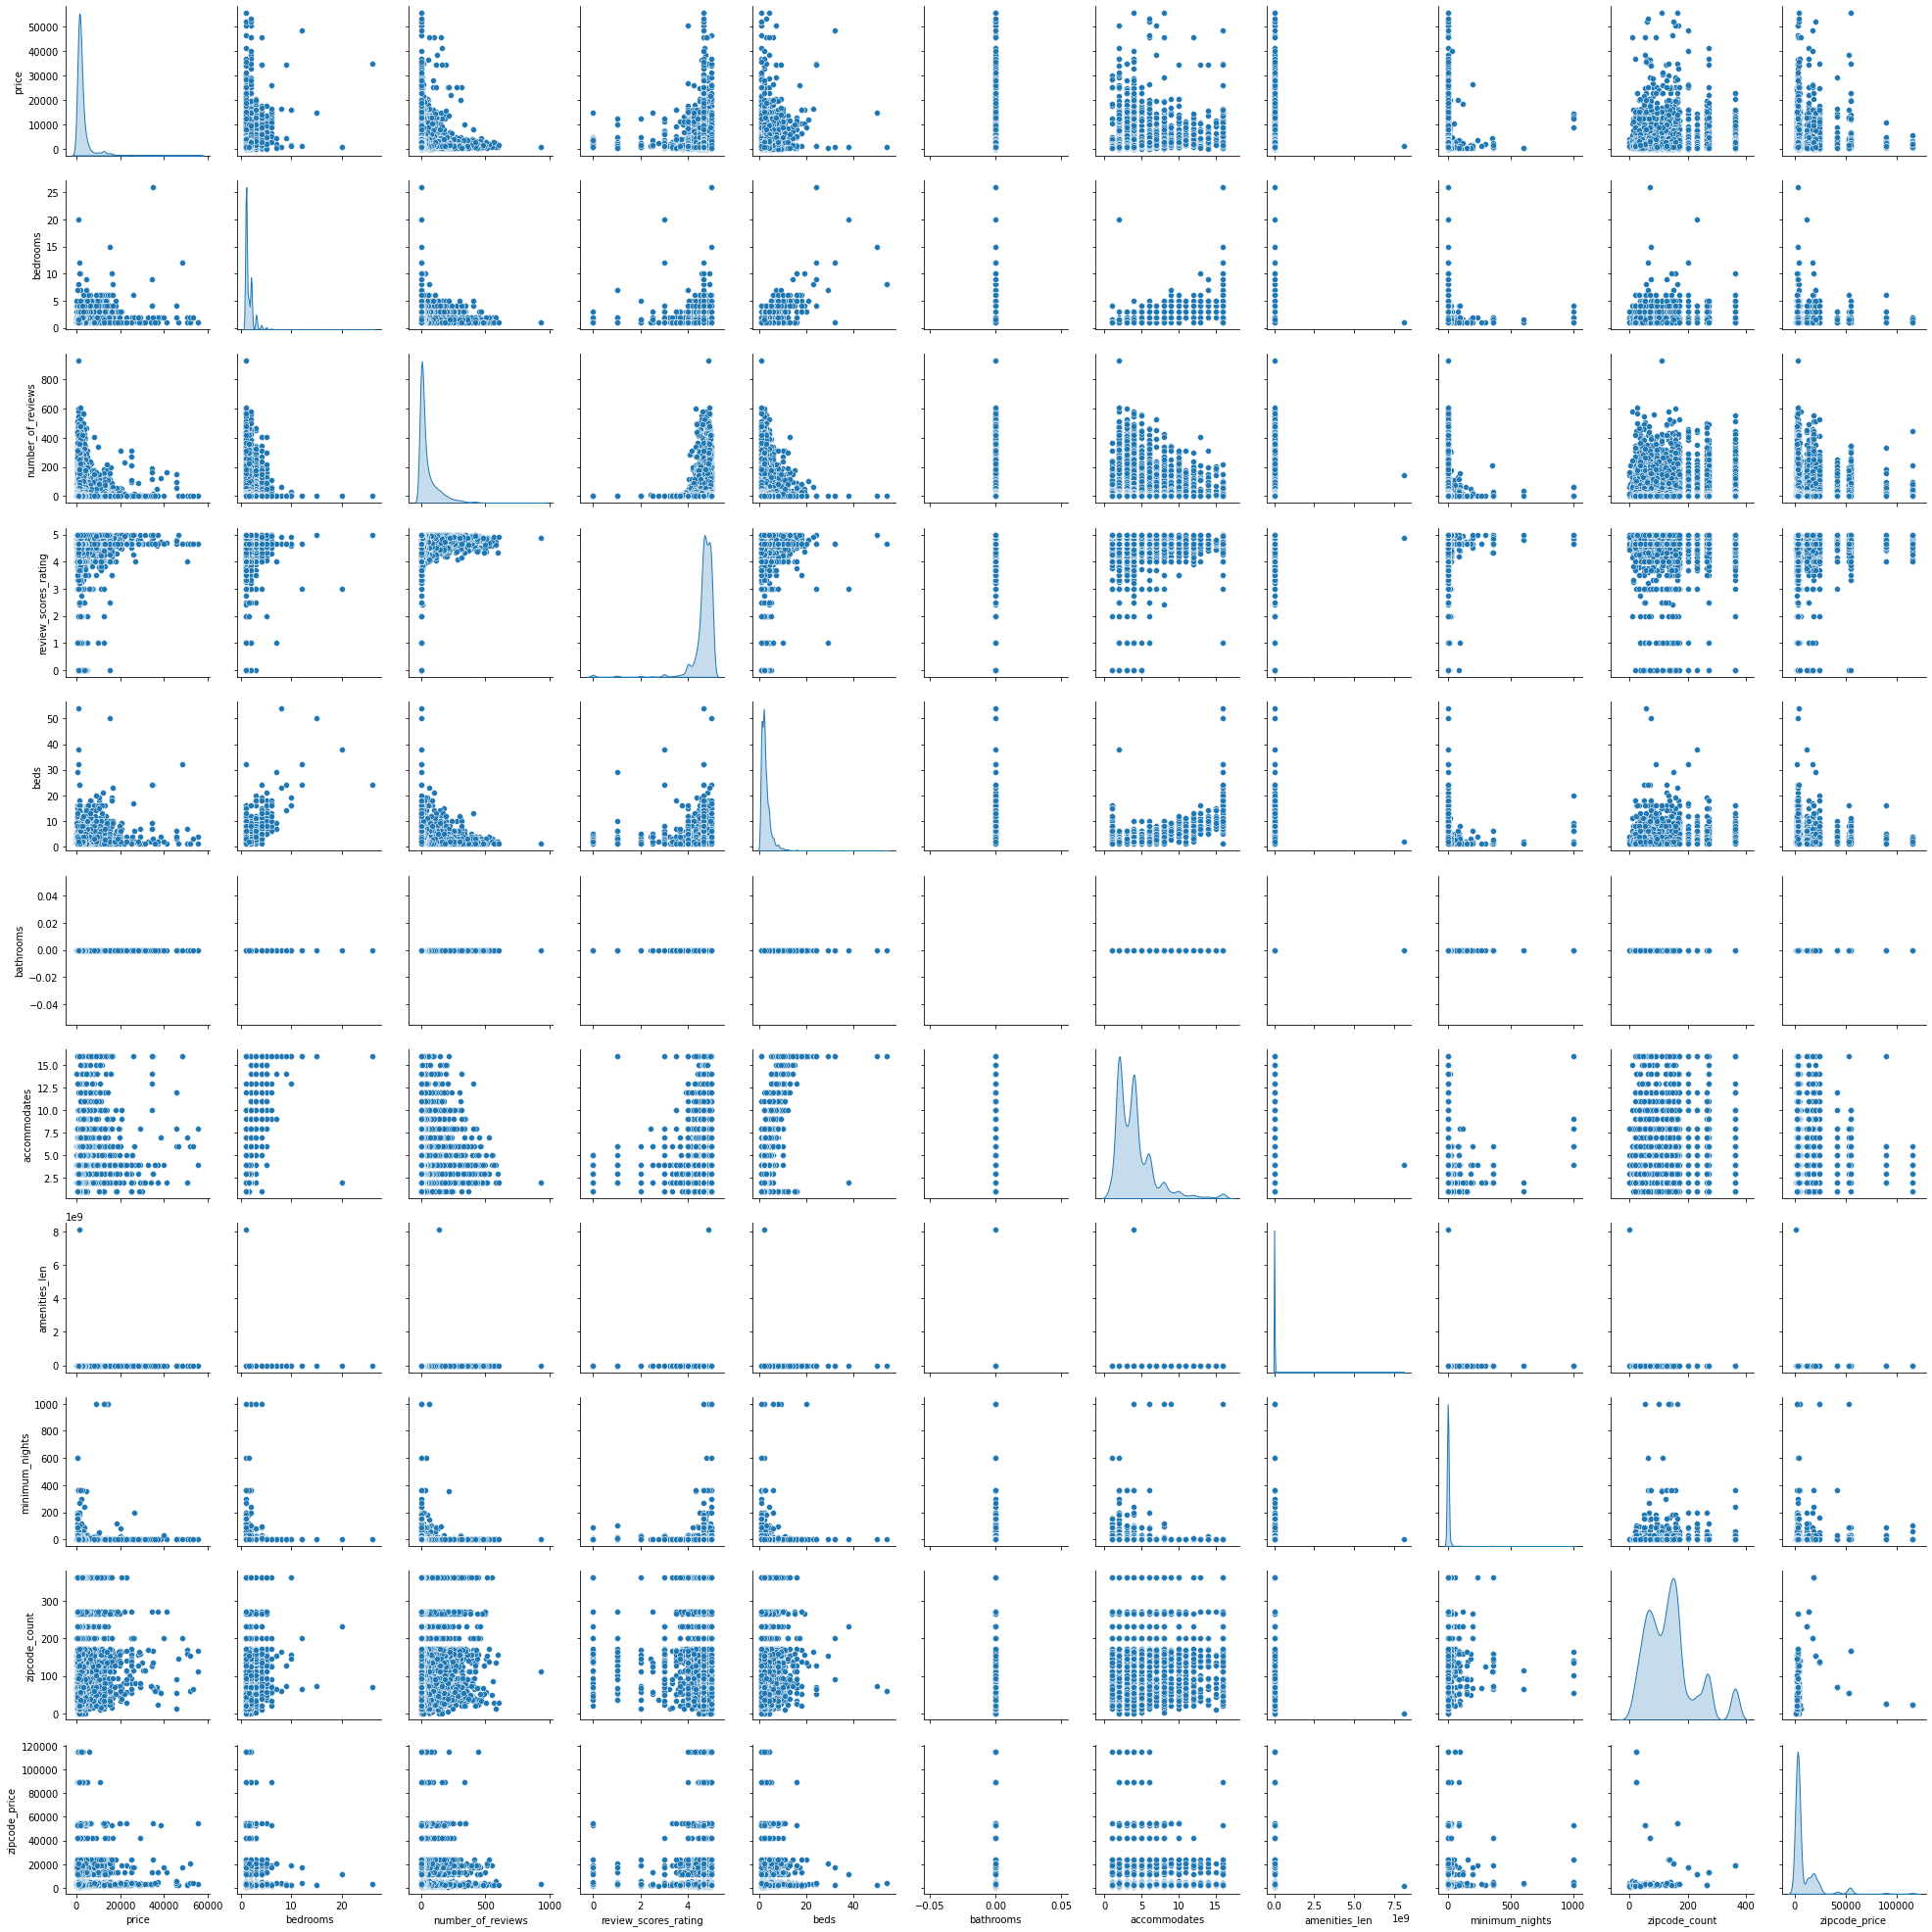

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.pairplot(data3[cols], height=2.5, diag_kind='kde')
plt.tight_layout()
plt.savefig('prague_matrix_pair_plot.png', dpi=300)

plt.show()
plt.clf() # Clean parirplot figure from sns

In [ ]:
print(data[cols].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22479 entries, 0 to 22551
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 22479 non-null  float64
 1   host_is_superhost     22454 non-null  object 
 2   bedrooms              22479 non-null  float64
 3   number_of_reviews     22479 non-null  float64
 4   review_scores_rating  22479 non-null  float64
 5   beds                  22479 non-null  float64
 6   bathrooms             22479 non-null  float64
 7   accommodates          22479 non-null  float64
 8   amenities_len         22479 non-null  float64
 9   minimum_nights        22479 non-null  float64
 10  zipcode_count         22479 non-null  float64
 11  zipcode_price         22479 non-null  float64
dtypes: float64(11), object(1)
memory usage: 2.2+ MB
None


In [ ]:
# Preparing data to show in heatmap
print(data[cols].describe())
print(data[cols].info())
data[cols].values.T
print(cols)
print(data[cols].info())
cols_for_heatmap = cols.copy()
cols_for_heatmap.remove('host_is_superhost')

              price      bedrooms  ...  zipcode_count  zipcode_price
count  22479.000000  22479.000000  ...   22479.000000   22479.000000
mean      58.308021      1.158809  ...     371.533253      66.299797
std       45.678653      0.637756  ...     242.231660      62.961177
min        1.000000      0.000000  ...       1.000000      20.000000
25%       30.000000      1.000000  ...     146.000000      50.030000
50%       45.000000      1.000000  ...     371.000000      57.971477
75%       70.000000      1.000000  ...     574.000000      67.370370
max      550.000000     10.000000  ...     855.000000    1113.288136

[8 rows x 11 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22479 entries, 0 to 22551
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 22479 non-null  float64
 1   host_is_superhost     22454 non-null  object 
 2   bedrooms              22479 non-null  

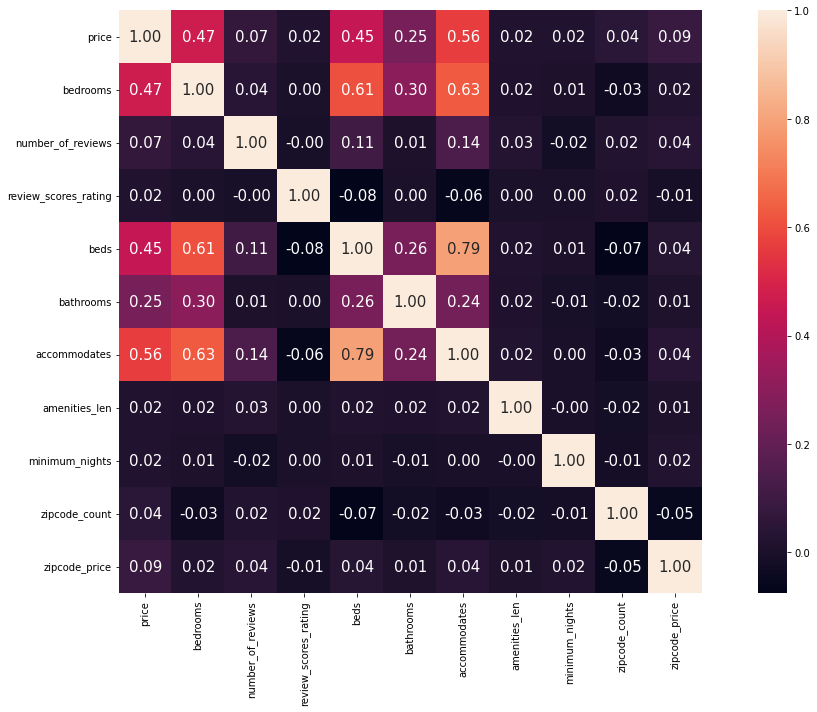

In [ ]:
cm = np.corrcoef(data[cols_for_heatmap].values.T)
plt.figure(figsize = (16,10))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols_for_heatmap,
                 xticklabels=cols_for_heatmap)

plt.tight_layout()
plt.savefig('berlin_heatmap.png', dpi=300)
plt.show()

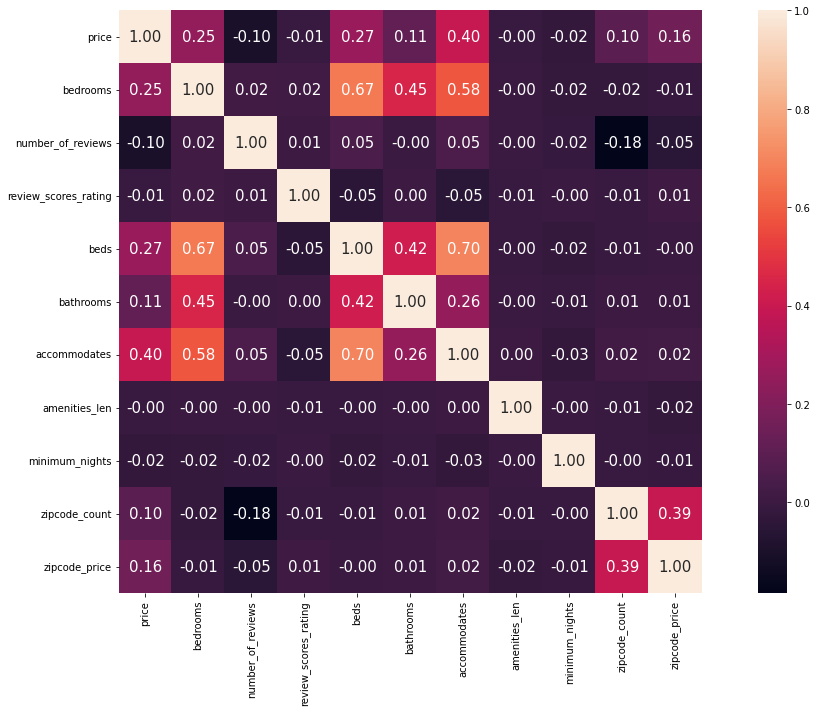

In [ ]:
cm = np.corrcoef(data2[cols_for_heatmap].values.T)
plt.figure(figsize = (16,10))

hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols_for_heatmap,
                 xticklabels=cols_for_heatmap)

plt.tight_layout()
plt.savefig('monachium_heatmap.png', dpi=300)
plt.show()

invalid value encountered in true_divide
invalid value encountered in true_divide


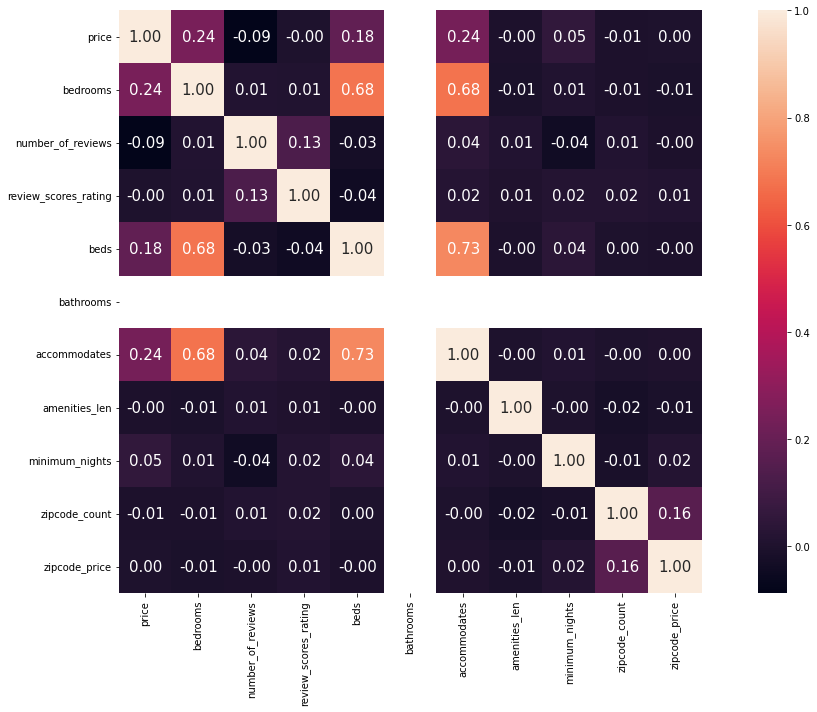

In [ ]:
cm = np.corrcoef(data3[cols_for_heatmap].values.T)
plt.figure(figsize = (16,10))

hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols_for_heatmap,
                 xticklabels=cols_for_heatmap)

plt.tight_layout()
plt.savefig('praga_heatmap.png', dpi=300)
plt.show()

# Estimating the coefficient of a regression model via scikit-learn
Perform regression using classic methods -> linear regression and polynomial regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Modeling nonlinear relationships in the Housing Dataset


Processing next city 


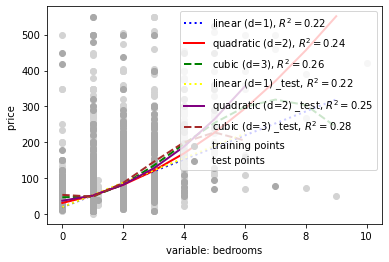

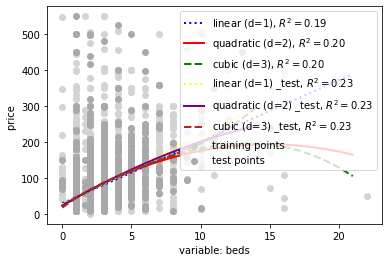

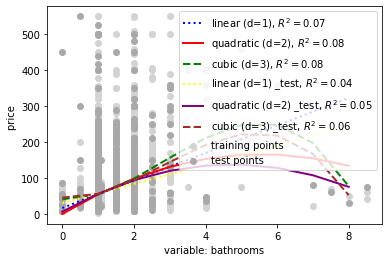

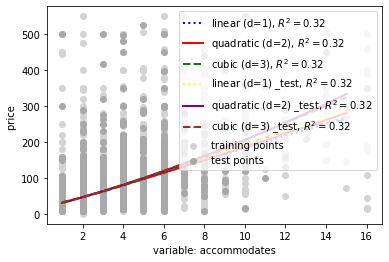

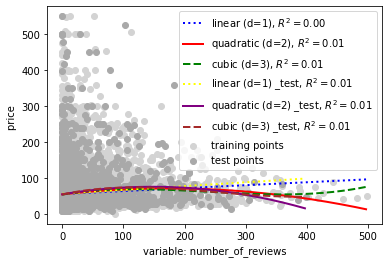

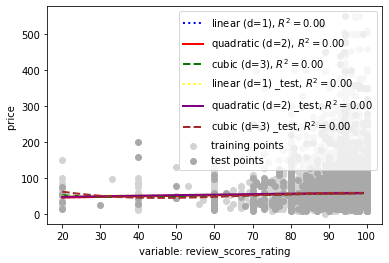

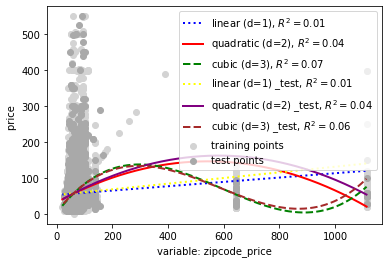

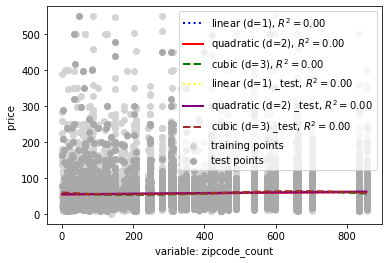

Processing next city 


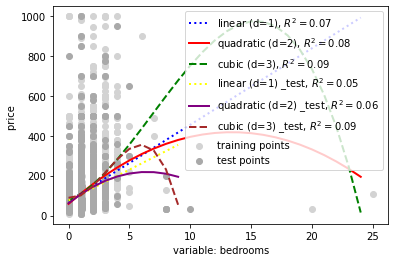

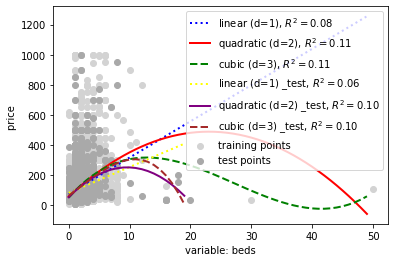

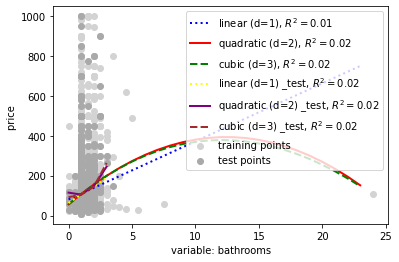

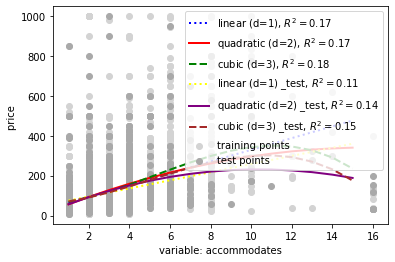

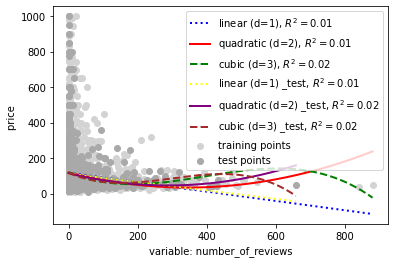

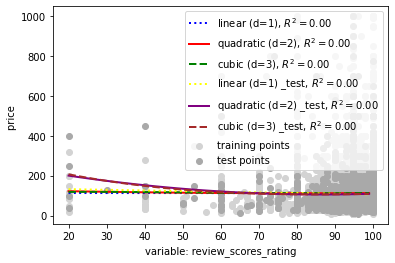

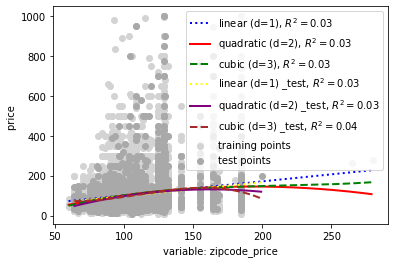

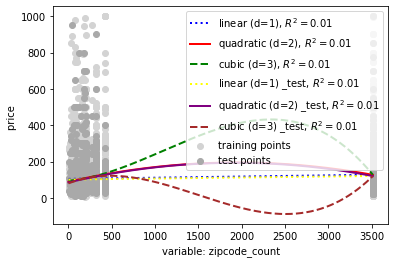

    cubic_mse_test  cubic_mse_train  ...  quadratic_r2_train              variable
0         1609.698         1509.888  ...               0.235              bedrooms
1         1719.490         1642.957  ...               0.198                  beds
2         2102.707         1877.084  ...               0.078             bathrooms
3         1510.194         1396.725  ...               0.317          accommodates
4         2208.443         2032.539  ...               0.007     number_of_reviews
5         2235.045         2047.468  ...               0.000  review_scores_rating
6         2091.493         1900.925  ...               0.036         zipcode_price
7         2227.109         2040.034  ...               0.002         zipcode_count
8         8047.125         9661.068  ...               0.081              bedrooms
9         7959.417         9475.409  ...               0.105                  beds
10        8648.659        10421.267  ...               0.020             bathrooms
11  

In [ ]:
results = pd.DataFrame()

cols = [ 'bedrooms', 'beds', 'bathrooms', 'accommodates', 'number_of_reviews','review_scores_rating', 'zipcode_price', 'zipcode_count']

set_of_data =[data, data2]
# set_of_data =[data, data2,data3]
set_of_city = ['berlin', 'monachium']
# set_of_city = ['berlin', 'monachium', 'praga']

city = 'berlin'
j_index = 0
i_index =0
for j in set_of_data:
    print("Processing next city ")
    for i in cols:
        X = j[[i]].values
        y = j['price'].values



        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        regr = LinearRegression()

        # create quadratic features
        quadratic = PolynomialFeatures(degree=2)
        cubic = PolynomialFeatures(degree=3)
        X_quad_train = quadratic.fit_transform(X_train)
        X_cubic_train = cubic.fit_transform(X_train)

        quadratic = PolynomialFeatures(degree=2)
        cubic = PolynomialFeatures(degree=3)
        X_quad_test = quadratic.fit_transform(X_test)
        X_cubic_test = cubic.fit_transform(X_test)


        # fit features
        X_fit_train = np.arange(X_train.min(), X_train.max(), 1)[:, np.newaxis]
        X_fit_test = np.arange(X_test.min(), X_test.max(), 1)[:, np.newaxis]


        regr = regr.fit(X_train, y_train)
        y_lin_fit_train = regr.predict(X_fit_train)
        y_train_pred = regr.predict(X_train)
        linear_r2_train = r2_score(y_train, y_train_pred)
        linear_mse_train =  mean_squared_error(y_train, y_train_pred)

        regr = regr.fit(X_test, y_test)
        y_lin_fit_test = regr.predict(X_fit_test)
        y_test_pred = regr.predict(X_test)
        linear_r2_test = r2_score(y_test, y_test_pred)
        linear_mse_test = mean_squared_error(y_test, y_test_pred)


        regr = regr.fit(X_quad_train, y_train)
        y_quad_fit_train = regr.predict(quadratic.fit_transform(X_fit_train))
        y_train_pred = regr.predict(X_quad_train)
        quadratic_r2_train = r2_score(y_train, y_train_pred)
        quadratic_mse_train = mean_squared_error(y_train, y_train_pred)

        regr = regr.fit(X_quad_test, y_test)
        y_quad_fit_test = regr.predict(quadratic.fit_transform(X_fit_test))
        y_test_pred = regr.predict(X_quad_test)
        quadratic_r2_test = r2_score(y_test, y_test_pred)
        quadratic_mse_test = mean_squared_error(y_test, y_test_pred)

        regr = regr.fit(X_cubic_train, y_train)
        y_cubic_fit_train = regr.predict(cubic.fit_transform(X_fit_train))
        y_train_pred = regr.predict(X_cubic_train)
        cubic_r2_train = r2_score(y_train, y_train_pred)
        cubic_mse_train = mean_squared_error(y_train, y_train_pred)

        regr = regr.fit(X_cubic_test, y_test)
        y_cubic_fit_test = regr.predict(cubic.fit_transform(X_fit_test))
        y_test_pred = regr.predict(X_cubic_test)
        cubic_r2_test = r2_score(y_test, y_test_pred)
        cubic_mse_test = mean_squared_error(y_test, y_test_pred)


        # plot results
        plt.scatter(X_train, y_train, label='training points', color='lightgray')
        plt.scatter(X_test, y_test, label='test points', color='darkgray')

        plt.plot(X_fit_train, y_lin_fit_train,
                 label='linear (d=1), $R^2=%.2f$' % linear_r2_train,
                 color='blue',
                 lw=2,
                 linestyle=':')

        plt.plot(X_fit_train, y_quad_fit_train,
                 label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2_train,
                 color='red',
                 lw=2,
                 linestyle='-')

        plt.plot(X_fit_train, y_cubic_fit_train,
                 label='cubic (d=3), $R^2=%.2f$' % cubic_r2_train,
                 color='green',
                 lw=2,
                 linestyle='--')

        plt.plot(X_fit_test, y_lin_fit_test,
                 label='linear (d=1) _test, $R^2=%.2f$' % linear_r2_test,
                 color='yellow',
                 lw=2,
                 linestyle=':')

        plt.plot(X_fit_test, y_quad_fit_test,
                 label='quadratic (d=2) _test, $R^2=%.2f$' % quadratic_r2_test,
                 color='purple',
                 lw=2,
                 linestyle='-')

        plt.plot(X_fit_test, y_cubic_fit_test,
                 label='cubic (d=3) _test, $R^2=%.2f$' % cubic_r2_test,
                 color='brown',
                 lw=2,
                 linestyle='--')

        plt.xlabel('variable: ' + i)
        plt.ylabel('price ')
        plt.legend(loc='upper right')

        plt.figsize = (50,50)
        plt.title = "test_title"
        #plt.annotate(ha='center', va='bottom', xy=(0,0), size =15)

        #plt.ylim([25.0, 300])
        #plt.figure(figsize=(30,30))

        #plt.savefig('images/10_11.png', dpi=300)
        new_row_train = {'variable':i, 'data': set_of_city[j_index],
                         'linear_r2_train':round(linear_r2_train, 3), 'quadratic_r2_train':round(quadratic_r2_train, 3), 'cubic_r2_train':round(cubic_r2_train, 3),
                          'linear_mse_train':round(linear_mse_train, 3), 'quadratic_mse_train':round(quadratic_mse_train, 3), 'cubic_mse_train':round(cubic_mse_train, 3),
                         'linear_r2_test':round(linear_r2_test, 3), 'quadratic_r2_test':round(quadratic_r2_test, 3), 'cubic_r2_test':round(cubic_r2_test, 3),
                          'linear_mse_test':round(linear_mse_test, 3), 'quadratic_mse_test':round(quadratic_mse_test, 3), 'cubic_mse_test':round(cubic_mse_test, 3)
                        }

        #new_row_test= {'zmienna':i, 'linear_r2':round(linear_r2_test, 3), 'quadratic_r2':round(quadratic_r2_test, 3), 'cubic_r2':round(cubic_r2_test, 3), 'data':'_test'}

        #print(new_row)
        results= results.append(new_row_train, ignore_index=True)
        #results= results.append(new_row_test, ignore_index=True)
        plt.savefig(f'{set_of_city[j_index]}_{i_index}_{i}.png', dpi=300)
        plt.show()
        i_index += 1
    j_index += 1
    i_index = 0
print(results)

In [ ]:
data.replace({'host_is_superhost' : {'t' : True, 'f' : False}}, inplace=True)
data2.replace({'host_is_superhost' : {'t' : True, 'f' : False}}, inplace=True)
data3.replace({'host_is_superhost' : {'t' : True, 'f' : False}}, inplace=True)

In [ ]:
str = 'bedrooms + beds + bathrooms + accommodates  + number_of_reviews + review_scores_rating + zipcode_price'
s1_1 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews + review_scores_rating'
s1_2 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews'
s1_3 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price'
s1_4 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count'
s1_5 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms'
s1_6 = 'host_is_superhost + accommodates + bedrooms + beds'
s1_7 = 'host_is_superhost + accommodates + bedrooms'
s1_8 = 'host_is_superhost + accommodates'
s1_9 = 'host_is_superhost'

s2_1 = 'accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews + review_scores_rating'
s2_2 = 'accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews'
s2_3 = 'accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price'
s2_4 = 'accommodates + bedrooms + beds + bathrooms + zipcode_count'
s2_5 = 'accommodates + bedrooms + beds + bathrooms'
s2_6 = 'accommodates + bedrooms + beds'
s2_7 = 'accommodates + bedrooms'
s2_8 = 'accommodates'

s1_1 = 'host_is_superhost  bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews + review_scores_rating'
s1_2 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews'
s1_3 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price'
s1_4 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms + zipcode_count'
s1_5 = 'host_is_superhost + accommodates + bedrooms + beds + bathrooms'
s1_6 = 'host_is_superhost + accommodates + bedrooms + beds'
s1_7 = 'host_is_superhost + accommodates + bedrooms'
s1_8 = 'host_is_superhost + accommodates'
s1_9 = 'host_is_superhost'


s2 = 'accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews + review_scores_rating'
s3 = 'accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price'
s3 = 'accommodates + bedrooms + beds + bathrooms + zipcode_price'
s4 = 'accommodates + bedrooms + beds'
s5 = 'accommodates + bedrooms'
s6 = 'bedrooms + beds'
s7 = 'accommodates + beds'
s8 = 'accommodates + zipcode_price'
s9 = 'accommodates + beds + zipcode_price'

tab = [s2, s3, s4, s5, s6, s7, s8, s9]
print(tab)

tab2 = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','host_is_superhost','number_of_reviews','review_scores_rating']







['accommodates + bedrooms + beds + bathrooms + zipcode_count + zipcode_price + number_of_reviews + review_scores_rating', 'accommodates + bedrooms + beds + bathrooms + zipcode_price', 'accommodates + bedrooms + beds', 'accommodates + bedrooms', 'bedrooms + beds', 'accommodates + beds', 'accommodates + zipcode_price', 'accommodates + beds + zipcode_price']


In [ ]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-
# linear-model-plot-lasso-coordinate-descent-path-py

#'host_is_superhost +
with open("Output.txt", "w") as text_file:
    print(f"start", file=text_file)

set_of_data =[data, data2,data3]
set_of_city = ['berlin', 'monachium', 'praga']
city = 'berlin'
j_index = 0
i_index =1
for j in set_of_data:
    for i in tab:
        model = smf.ols('price ~ ' + i, data=j).fit()
        wynik = model.summary()
        print(wynik)
        with open("Output.txt", "a") as text_file:
            print(f"###############miasto: {set_of_city[j_index]}", file=text_file)
            print(f"$$$$$$$$$ciąg zmiennych nr:{i_index} {i}", file=text_file)
            print(f"{wynik}", file=text_file)
            print("\n\n")

        i_index += 1
    j_index += 1

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     1577.
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:08:51   Log-Likelihood:            -1.1279e+05
No. Observations:               22479   AIC:                         2.256e+05
Df Residuals:                   22470   BIC:                         2.257e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -42.7828 

divide by zero encountered in double_scalars
invalid value encountered in true_divide



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     203.3
Date:                Fri, 21 Jan 2022   Prob (F-statistic):           1.82e-86
Time:                        16:08:52   Log-Likelihood:                -65904.
No. Observations:                6752   AIC:                         1.318e+05
Df Residuals:                    6749   BIC:                         1.318e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1307.0935     95.044     13.752  

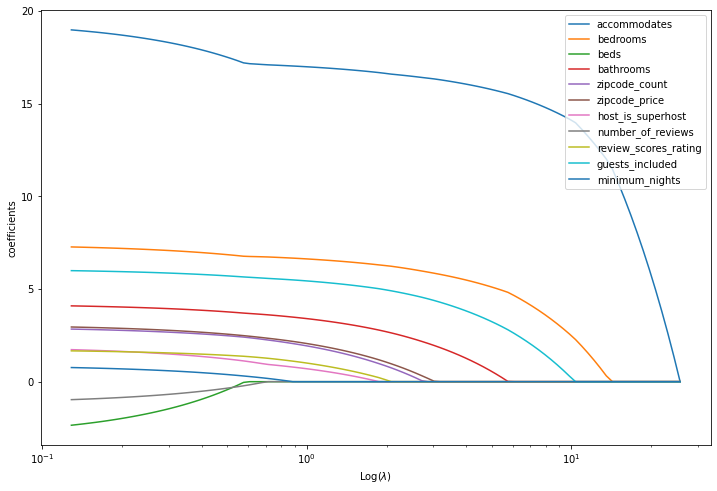

In [ ]:
variables = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','host_is_superhost','number_of_reviews','review_scores_rating', 'guests_included', 'minimum_nights']


data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps=5e-3)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
#plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

plt.savefig('berlin_lasso.png', dpi=300)

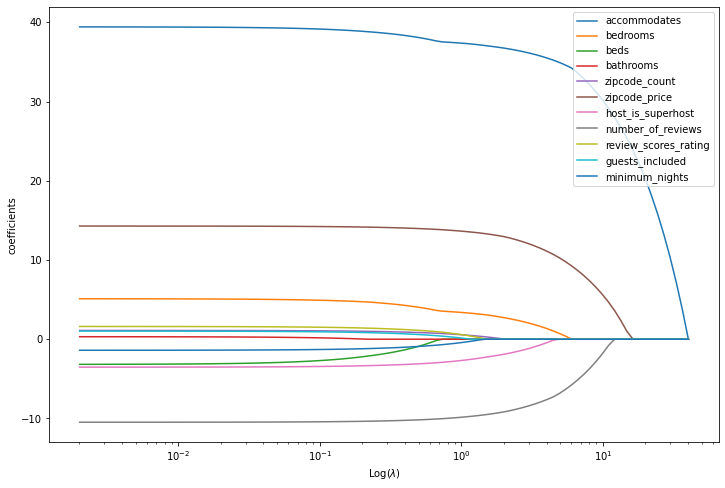

In [ ]:
variables = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','host_is_superhost','number_of_reviews','review_scores_rating', 'guests_included', 'minimum_nights']


data_subset = data2.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps=5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
#plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

plt.savefig('monachium_lasso.png', dpi=300)

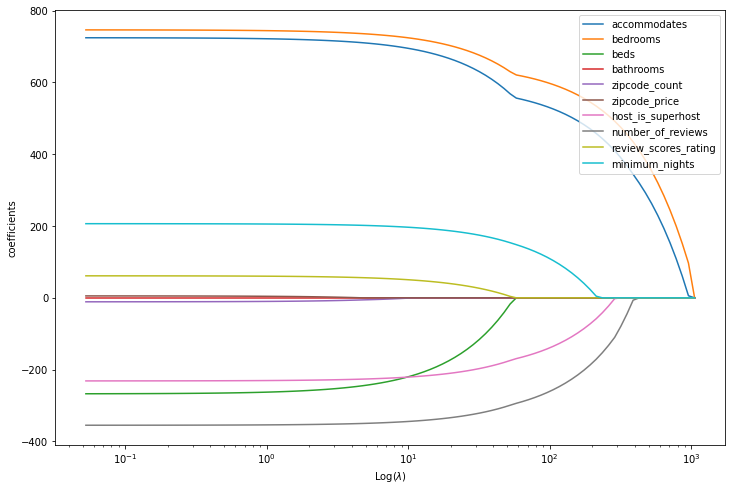

In [ ]:
variables = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','host_is_superhost','number_of_reviews','review_scores_rating', 'minimum_nights']


data_subset = data3.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps=5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
#plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

plt.savefig('praga_lasso.png', dpi=300)

In [ ]:
# XGBoost
# 'guests_included',
variables = ['bathrooms', 'bedrooms', 'beds',  'minimum_nights', 'number_of_reviews', 'review_scores_rating']
variables = cols
variables = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','number_of_reviews','review_scores_rating', 'guests_included', 'minimum_nights']


data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that
y = np.array(data_subset.price)

model = xgboost.XGBRegressor(n_estimators=10)
model.fit(X, y)

[11:17:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10)

In [ ]:
# XGBoost
# 'guests_included',
variables = ['bathrooms', 'bedrooms', 'beds',  'minimum_nights', 'number_of_reviews', 'review_scores_rating']
variables = cols
variables = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','number_of_reviews','review_scores_rating', 'guests_included', 'minimum_nights']


data_subset = data2.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

X2 = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that
y2 = np.array(data_subset.price)

model2 = xgboost.XGBRegressor(n_estimators=10)
model2.fit(X2, y2)

[11:17:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10)

In [ ]:
# XGBoost
# 'guests_included',
variables = ['bathrooms', 'bedrooms', 'beds',  'minimum_nights', 'number_of_reviews', 'review_scores_rating']
variables = cols
variables = ['accommodates','bedrooms','beds','bathrooms','zipcode_count','zipcode_price','number_of_reviews','review_scores_rating', 'minimum_nights']


data_subset = data3.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

X3 = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that
y3 = np.array(data_subset.price)

model3 = xgboost.XGBRegressor(n_estimators=10)
model3.fit(X3, y3)

[11:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10)

In [ ]:
predicted = model.predict(X)
mean_squared_error(y, predicted)
#What does it even mean? Todo: check different error functions and how they can be explained
#Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

1526.497537193708

In [ ]:
predicted2 = model2.predict(X)
mean_squared_error(y2, predicted2)
#What does it even mean? Todo: check different error functions and how they can be explained
#Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

9258.08114264153

In [ ]:
Xpraga = X.drop(columns=['guests_included'])
predicted3 = model3.predict(Xpraga)
mean_squared_error(y3, predicted3)

9758465.793019783

In [ ]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
X.iloc[0,:]

accommodates              3.0
bedrooms                  1.0
beds                      2.0
bathrooms                 1.0
zipcode_count           538.0
zipcode_price            88.5
number_of_reviews       118.0
review_scores_rating     93.0
guests_included           1.0
minimum_nights            4.0
Name: 0, dtype: float64

In [ ]:
#Playing with Shapley values
explainer2 = shap.TreeExplainer(model2)
shap_values2 = explainer2.shap_values(X2)
X2.iloc[0,:]

accommodates              2.000000
bedrooms                  1.000000
beds                      1.000000
bathrooms                 1.000000
zipcode_count           417.000000
zipcode_price           184.453237
number_of_reviews        25.000000
review_scores_rating     98.000000
guests_included           1.000000
minimum_nights            2.000000
Name: 0, dtype: float64

In [ ]:
#Playing with Shapley values
explainer3 = shap.TreeExplainer(model3)
shap_values3 = explainer3.shap_values(X3)
X3.iloc[0,:]

accommodates                3.000000
bedrooms                    1.000000
beds                        2.000000
bathrooms                   0.000000
zipcode_count             362.000000
zipcode_price           18629.168508
number_of_reviews           2.000000
review_scores_rating        5.000000
minimum_nights              5.000000
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X2.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer3.expected_value, shap_values3[0,:], X3.iloc[0,:])

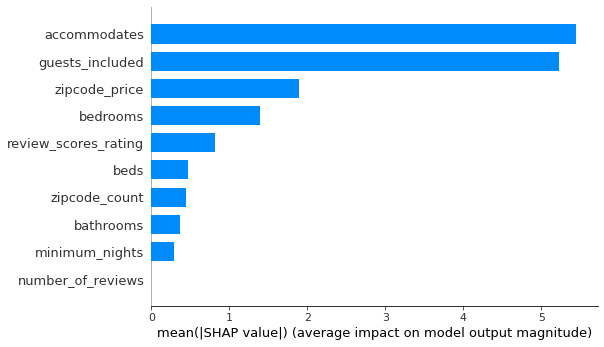

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

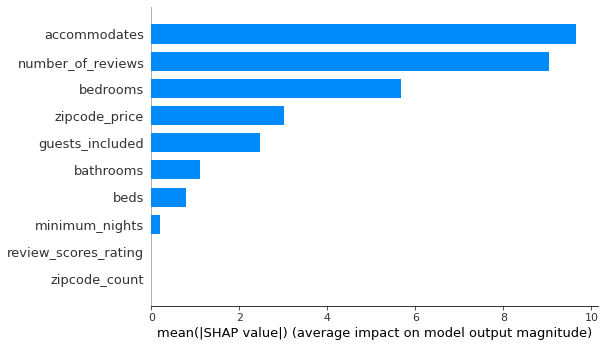

In [ ]:
shap.summary_plot(shap_values2, X2, plot_type="bar")

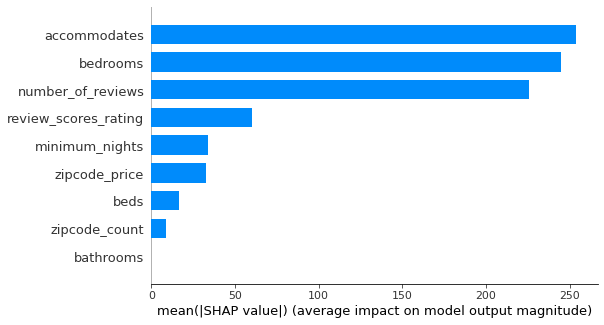

In [ ]:
shap.summary_plot(shap_values3, X3, plot_type="bar")

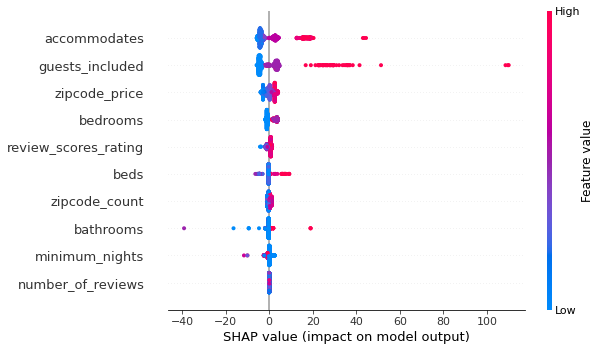

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

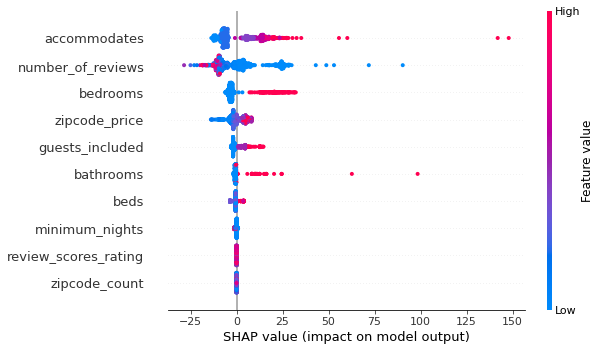

In [ ]:
shap.summary_plot(shap_values2, features=X2, feature_names=X2.columns)

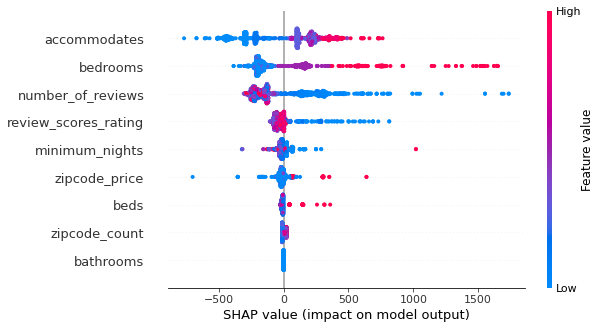

In [ ]:
shap.summary_plot(shap_values3, features=X3, feature_names=X3.columns)

In [ ]:
data.guests_included.describe()

count    22479.000000
mean         1.330041
std          0.827136
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: guests_included, dtype: float64

In [ ]:
data2.guests_included.describe()

count    11454.000000
mean         1.376113
std          3.309518
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        200.000000
Name: guests_included, dtype: float64